# Exploration

In [2]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

In [16]:
bundle_root = Path(os.environ['LABS_BUNDLE_ROOT'])
data_processed = bundle_root / 'data' / 'processed'

In [19]:
dat = pd.read_parquet(data_processed / 'wikipedia_referer.parquet')

## Clean data

### Only keep internal referers

In [20]:
dat['type'].value_counts()

link        16647016
other         843609
external           1
Name: type, dtype: int64

We have one row where `type == external`, which should be impossible since we're only looking at data where Wikipedia was the referer. Remove this row of bad data. 

In [7]:
dat.loc[dat['type'] == 'external']

,prev,curr,type,n
25776972,Quotation_mark,_(disambiguation)\tlink\t238\nother-empty\t_(d...,external,180


Furthermore, we're not interested in `type == other`. This only occurs when the client manually searches or [spoofs](https://en.wikipedia.org/wiki/Referer_spoofing) their refer. Since it is a small proportion of the data (~4.8%), and since we cannot say much about it (why is the most frequest request `Hyphen-minus`?), we'll remove this case from the data. 

In [8]:
dat.groupby(['curr', 'type']).sum().sort_values('n', ascending=False).head(1)

,,n
curr,type,
Hyphen-minus,other,8155828


In [9]:
df = dat.loc[dat['type'] == 'link', ['prev', 'curr', 'n']]

## Analysis

### Top requests

The following pages are the most common requests. The list is dominated by pages related to popular TV shows (_Black Mirror_, _The Crown_, _American Crime Story_). 

In [10]:
df.groupby('curr').sum().sort_values('n', ascending=False).head(10)

,n
curr,
Deaths_in_2018,1348006
List_of_Black_Mirror_episodes,688464
Elizabeth_II,584683
George_VI,450487
Edward_VIII,376746
Dolores_O'Riordan,372236
George_V,350654
"Charles,_Prince_of_Wales",347034
Andrew_Cunanan,330003


### Distribution of pairing counts

Note that the distribution of pairings counts follows a Poisson distribution. We should keep this in mind when it comes time to choose the appropriate model (e.g., linear regression would not do well here). 

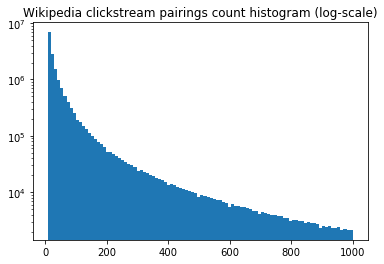

In [11]:
dfp = df[df['n'] <= 1000]
plt.hist(dfp['n'], bins=100, log=True)
plt.title("Wikipedia clickstream pairings count histogram (log-scale)");

## Write to disk

In [15]:
df.to_parquet(data_processed / 'clean.parquet')